__Project:__ Simple DNN and CNN <br>
__Sub-prj:__ DNN Regression with Keras <br>
__Experm:__ Data Prep & Regression on Tabular Data (Big Mart Sales Pred) <br>
__Devl by:__ Amir Hossini <br>
__Dev Dat:__ Oct 9, 2021 <br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amirhossini/Tensorflow-Notebooks/blob/main/00-Simple_DNN_and_CNN/BigMart_Sales_Prediction.ipynb)

#### Libraries

In [34]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt

print(f'Tensorflow Version: {tf.__version__}')
print('Number of available GPUs: {}'.format(len(tf.config.list_physical_devices('GPU'))))

Tensorflow Version: 2.5.0
Number of available GPUs: 1


#### I/O Files & Params

In [4]:
fl_train     = './datasets/big_mart_sales/train.csv'
fl_test      = './datasets/big_mart_sales/test.csv'

excl_list    = ['Item_Identifier']
ordinal_list = ['Outlet_Location_Type']
nominal_list = ['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Establishment_Year','Outlet_Size','Outlet_Type']

ordinal_labels_dict = {
    'Outlet_Location_Type':{'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2},
}

item_fat_content_map = {
    'Low Fat':'LF', 'Regular':'Reg', 'low fat':'LF', 'LF':'LF', 'reg':'Reg'
}

target_var = ['Item_Outlet_Sales']

val_split = 0.3

#### Functions

In [40]:
def prep_ordinal(dataframe,columns,ordinal_labels_dict):
    df = dataframe.copy()
    for col in columns:
        label_dict = ordinal_labels_dict[col]
        df.loc[:,col] = df.loc[:,col].map(lambda x: label_dict[x])
    return df
    
def prep_nominal(dataframe,columns):
    df = dataframe.copy()
    for col in columns:
        tmp_df=pd.get_dummies(df[col],prefix=col)
        tmp_df=tmp_df.iloc[: , :-1]
        df.drop(columns=[col],inplace=True)
        df=pd.concat([df,tmp_df],axis=1)
    return df

def prep_normalize(dataframe):
    df = dataframe.copy()
    df_scaled=pd.DataFrame(MinMaxScaler().fit_transform(df),columns=df.columns)
    return df_scaled

def split_data(dataframe,target_col,test_split_prop=0.2):
    df = dataframe.copy()
    X  = df.drop(columns=target_col)
    y  = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_split_prop)
    return X_train, X_test, y_train, y_test

def r2_metric(y_actual,y_predicted):
    SS_res = K.sum(K.square( y_actual - y_predicted ))
    SS_tot = K.sum(K.square( y_actual - K.mean(y_actual) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def dnn_regress_model_compile(X,n_layer1=64,n_layer2=32,dropout_rate=0.2,lr=0.001):
    model = Sequential([
        Dense(n_layer1, activation = 'relu', input_dim = X.shape[1]),
        Dropout(dropout_rate),
        Dense(n_layer2, activation = 'relu'),
        Dropout(dropout_rate),
        Dense(1,activation = 'relu')                    
    ])
    
    model.compile(loss='mean_absolute_error', optimizer=RMSprop(learning_rate=lr),metrics=[r2_metric])
    return model

#### Read In & Stats

In [26]:
train = pd.read_csv(fl_train)
test  = pd.read_csv(fl_test)

print(f'Train Size: {len(train)}')
print(f'Test Size: {len(test)}')
print('\nPercentage of missing: Train')
print(train.isna().sum()/len(train)*100)

print('\nPercentage of missing: Test')
print(test.isna().sum()/len(test)*100)

Train Size: 8523
Test Size: 5681

Percentage of missing: Train
Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

Percentage of missing: Test
Item_Identifier               0.000000
Item_Weight                  17.180074
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.269671
Outlet_Location_Type          0.000000
Outlet_Type                   0.000

#### Missing data handling & cleaning

In [27]:
train.loc[train['Item_Weight'].isna(),'Item_Weight'] = train['Item_Weight'].mean()
test.loc[test['Item_Weight'].isna(),'Item_Weight'] = test['Item_Weight'].mean()

train.loc[train['Outlet_Size'].isna(),'Outlet_Size'] = 'Unknown'
test.loc[test['Outlet_Size'].isna(),'Outlet_Size'] = 'Unknown'

train.loc[:,'Item_Fat_Content']=train.loc[:,'Item_Fat_Content'].map(lambda x: item_fat_content_map[x])
test.loc[:,'Item_Fat_Content']=test.loc[:,'Item_Fat_Content'].map(lambda x: item_fat_content_map[x])

train.drop(columns=['Item_Identifier'],inplace=True)
test.drop(columns=['Item_Identifier'],inplace=True)

#### Feature Engineering

In [28]:
train=(train.pipe(prep_ordinal,ordinal_list,ordinal_labels_dict)
    .pipe(prep_nominal,nominal_list)
    .pipe(prep_normalize)
)

test=(test.pipe(prep_ordinal,ordinal_list,ordinal_labels_dict)
    .pipe(prep_nominal,nominal_list)
    .pipe(prep_normalize)
)

In [29]:
X_train, X_val, y_train, y_val = split_data(train,target_var,val_split)

In [43]:
ml_model = dnn_regress_model_compile(X_train,n_layer1=64,n_layer2=16,dropout_rate=0.1,lr=0.0001)
print(ml_model.summary())
history = ml_model.fit(X_train,y_train,validation_data=(X_val, y_val), epochs=100)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                2816      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 17        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
187/187 [==============================] - 1s 5ms/step - loss: 0.1323 - r2_metric: -0.8803 - val_loss

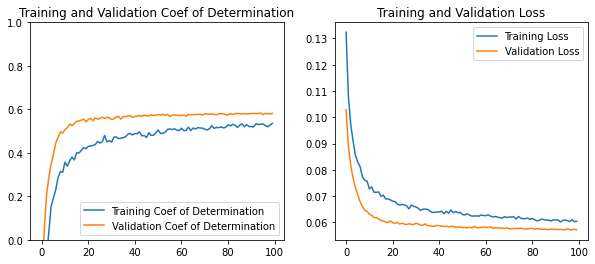

In [44]:
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['r2_metric'], label='Training Coef of Determination')
plt.plot(epochs_range, history.history['val_r2_metric'], label='Validation Coef of Determination')
plt.legend(loc='lower right')
plt.title('Training and Validation Coef of Determination')
plt.ylim([0,1])

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()